In [1]:
import pystan
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GoodwinModel(object):

    def __init__(self, y0=None):

        if y0 is None:
            self._y0 = np.array([0,0,0], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
            
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
        #print(parameters.shape)
        a1, a2, alpha, k1, k2 = [float(x) for x in parameters]
        times = np.asarray(times)

        def r(y, t, p):
            
            X1, X2, X3=y
            dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
            dX2_dt = (k1*X1) - (alpha*X2);
            dX3_dt = (k2*X2) - (alpha*X3);
            
            return dX1_dt,dX2_dt,dX3_dt

        if sensitivities:
            def jac(y):
                X1, X2, X3 = y
                ret = np.empty((3, 3))
                ret[0, 0] = -alpha
                ret[0, 1] = 0
                ret[0, 2] = -(a1*a2*10*(X3**9))/( (1 + a2*(X3**10))**2 )
                
                ret[1, 0] = k1
                ret[1, 1] = -alpha
                ret[1, 2] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = k2
                ret[2, 2] = -alpha
                return ret

            def dfdp(y):
                X1, X2, X3 = y
                ret = np.empty((3, 5))
                ret[0, 0] = 1/(1+a2*(X3**10))
                ret[0, 1] = -(a1*(X3**10))/( (1 + a2*(X3**10))**2 )
                ret[0, 2] = -X1
                ret[0, 3] = 0
                ret[0, 4] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = 0
                ret[1, 2] = -X2
                ret[1, 3] = X1
                ret[1, 4] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = 0
                ret[2, 2] = -X3
                ret[2, 3] = 0
                ret[2, 4] = X2               
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:3]
                dydp = y_and_dydp[3:].reshape((3, 5))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(18)
            y0[0:3] = self._y0
            result = odeint(rhs, y0, times, (parameters,), rtol=1e-5, atol=1e-6)
            values = result[:, 0:3]
            dvalues_dp = result[:, 3:].reshape((len(times), 3, 5))
            return values, dvalues_dp
        else:
            values = odeint(r, self._y0, times, (parameters,), rtol=1e-5, atol=1e-6)
            return values
ode_model = GoodwinModel();

Text(0, 0.5, 'Value')

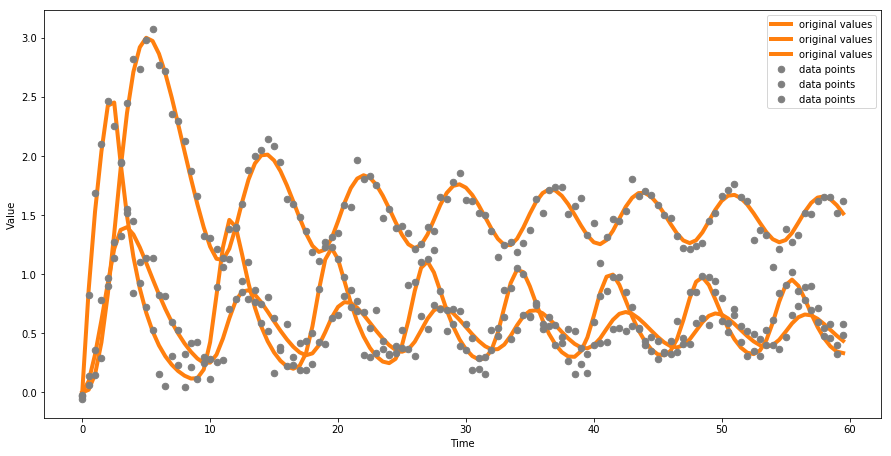

In [3]:
times = np.arange(0,60, 0.5)
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=ode_model.simulate(real_params, times)
np.random.seed(121) #np.random.seed(111)
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

In [4]:
import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer.autoguide import AutoIAFNormal, AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TracePredictive
from pyro.optim import ClippedAdam, AdagradRMSProp

In [5]:
def forwardModel(params):
    times = np.arange(0,60, 0.5)
    
    values = ode_model.simulate_with_sensitivities(params, times)[0]
    
    return values

def backwardModel(params):
    times = np.arange(0,60, 0.5)
    #print(params)
    sol, jac = ode_model.simulate_with_sensitivities(params, times)#[1].reshape((3*len(times),len(params)))
    
    return sol, jac

In [6]:
class ODEop(Function):
    
    @staticmethod
    def forward(ctx, x):
        numpy_x = x.detach().numpy()
        sol, Jac = backwardModel(numpy_x)
        ctx.save_for_backward(torch.as_tensor(Jac, dtype=x.dtype))
        return x.new(sol)

    @staticmethod
    def backward(ctx, grad_output):
        T = 120
        d = 5
        bJac = ctx.saved_tensors[0]
        numpy_Jac = bJac.detach().numpy().reshape((3*T,d))
        v = grad_output.detach().numpy()
        #print(backProp.shape)
        #print(v.reshape(40).shape)
        return grad_output.new(numpy_Jac.T.dot(v.reshape(3*T)))
def my_ODE_func(parameters):
    #print(parameters)
    return ODEop.apply(parameters)

In [7]:
class OdeModel(nn.Module):
    def __init__(self):
        
        super(OdeModel, self).__init__()
        
        self.factors = nn.Parameter(torch.empty(5))
        
        
    def forward(self,x):
        
        return my_ODE_func(self.factors) 

my_ode_model = OdeModel()

In [8]:
y_torch = torch.tensor(Y,dtype=torch.float)

In [9]:
def model(y_data):
    # weight and bias priors

    factors_prior = dist.Gamma(torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1)
    
    priors = {'factors': factors_prior}
    scale = pyro.sample("scale", dist.HalfNormal(1.0))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", my_ode_model, priors)
    # sample a nn (which also samples w and b)
    lifted_ode_model = lifted_module()
    #print(len(y_data))
    prediction_mean = lifted_ode_model(y_data)
    #print(torch.mean(prediction_mean,axis=0))
    with pyro.plate("map", len(y_data)):

        pyro.sample("obs",
                    Normal(prediction_mean, scale).to_event(1),
                    obs=y_data)
        return prediction_mean, lifted_ode_model

In [38]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=5)
lifted_model = model(y_torch)[1]

In [39]:
def train():

    loss_trace = []
    for j in range(30000):
        # calculate the loss and take a gradient step

        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
#        if np.mean(loss_trace[-100:]) <-200 and j>1000:
#            break;
    return loss_trace


In [40]:
%%time
loss_graph = train()
for name, param in lifted_model.named_parameters():
        print(name, param.data.numpy())

[iteration 0001] loss: 419.2094
[iteration 0501] loss: 104.9929
[iteration 1001] loss: 7.1746
[iteration 1501] loss: -153.2976
[iteration 2001] loss: -237.8364
[iteration 2501] loss: -266.8384
[iteration 3001] loss: -276.4308
[iteration 3501] loss: -283.0819
[iteration 4001] loss: -289.1233
[iteration 4501] loss: -288.7410
[iteration 5001] loss: -291.5727
[iteration 5501] loss: -293.0890
[iteration 6001] loss: -293.8677
[iteration 6501] loss: -294.1759
[iteration 7001] loss: -294.7016
[iteration 7501] loss: -295.4890
[iteration 8001] loss: -296.2972
[iteration 8501] loss: -296.0615
[iteration 9001] loss: -296.4222
[iteration 9501] loss: -297.1560
[iteration 10001] loss: -297.8680
[iteration 10501] loss: -297.7172
[iteration 11001] loss: -297.4677
[iteration 11501] loss: -297.5306
[iteration 12001] loss: -298.3401
[iteration 12501] loss: -297.7702
[iteration 13001] loss: -297.7989
[iteration 13501] loss: -298.3985
[iteration 14001] loss: -299.7225
[iteration 14501] loss: -298.6407
[iter

In [41]:
svi.num_samples = 1000
posterior = svi.run(y_torch)

get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
pyro_params = get_marginal(posterior, ['module$$$factors'])
pyro_vb_params=pyro_params.reshape((1000,5))

In [55]:
pyro_vb_params1 = get_marginal(posterior, ['scale']).reshape((-1,1))
vb_params=np.concatenate((pyro_vb_params,pyro_vb_params1),axis=1)
np.savetxt('paper_gw_vb.txt',vb_params)
vb_params.shape

(1000, 6)

In [25]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(y_torch)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 3000/3000 [52:46,  1.06s/it, step size=2.23e-01, acc. prob=0.930]


In [56]:
pyromc_params = hmc_samples['module$$$factors'][::2,:]
pyromc_params1 = hmc_samples['scale'].reshape((-1,1))[::2,:]
pyromc_params1.shape
mc_params=np.concatenate((pyromc_params,pyromc_params1),axis=1)
np.savetxt('paper_gw_mc.txt',mc_params)
mc_params.shape


(1000, 6)

In [124]:
vb_params_adj=np.loadtxt('./VBODE/paper_gw_vb_adj.txt')

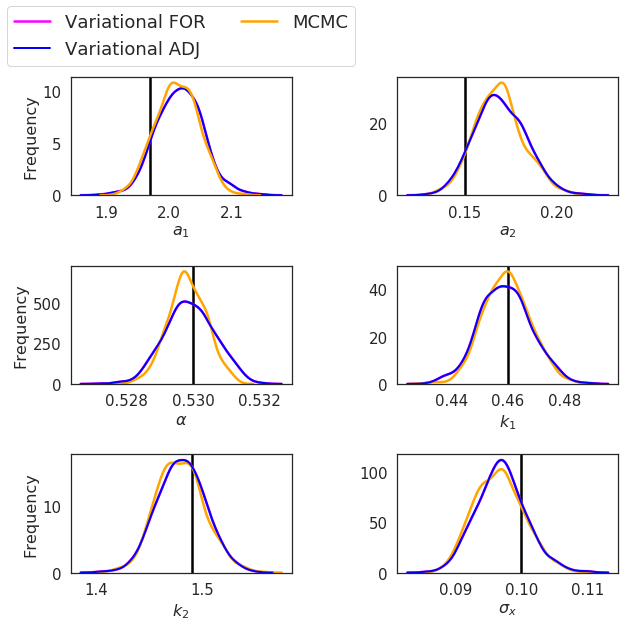

In [128]:
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")#(10,9)

param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]
T_lines = [1.97,0.15,0.53,0.46,1.49,0.1]
for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(3, 2, i+1)
        plt.axvline(T_lines[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational FOR')
            sns.kdeplot(vb_params_adj[:, i], color='blue',linewidth = 2, label='Variational ADJ')
            sns.kdeplot(mc_params[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params[:, i], linewidth = 2.5, color='orange')  
            sns.kdeplot(vb_params_adj[:, i], color='blue', linewidth = 2.)
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.savefig('gw.eps')

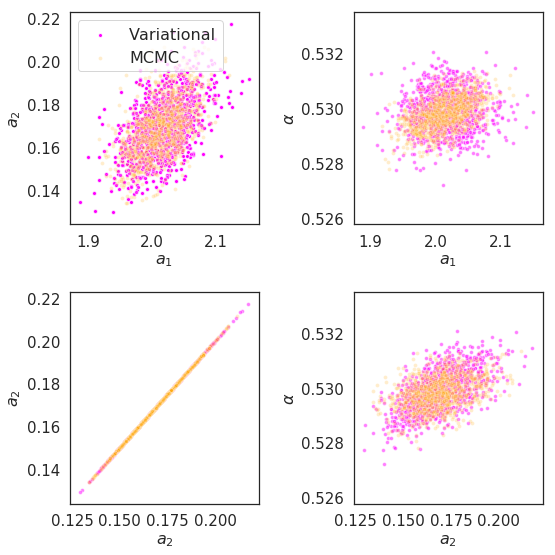

In [120]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$"]
fig_size = (8, 8)
fig, axes = plt.subplots(2, 2, figsize=fig_size)
for i in range(2):
    for j in range(2):
        if i==0 and j==0:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+1], 
                            ax=axes[i, j], s=15, alpha=1, edgecolors='none',
                            color = 'magenta', label='Variational');
            sns.scatterplot(vb_params[:, i], vb_params[:, j+1], 
                            ax=axes[i, j], s=15, alpha=0.5, edgecolors='none',
                            color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+1], 
                            ax=axes[i, j], s=15, alpha=0.2, edgecolors='none',
                            color = 'orange', label='MCMC');  
            axes[i,j].legend(fontsize=16)
        else:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+1], 
                        ax=axes[i, j], s=15, alpha=0.5, edgecolors='none', color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+1], 
                        ax=axes[i, j], s=15, alpha=0.2, edgecolors='none', color = 'orange');
        axes[i,j].set_xlabel(param_names[i])
        axes[i,j].set_ylabel(param_names[j+1])
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.savefig('gw_pairs.eps')

In [121]:
import scipy.stats as stats
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_context("paper", font_scale=1)
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$"]#
def pairwise(samples1,samples2,
             ref_parameters=None,
             parameter_names=None):

    sampler = 'RWM'
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    n_sample, n_param = samples1.shape
    fig_size = (3 * n_param, 3 * n_param)
    fig, axes = plt.subplots(n_param, n_param, figsize=fig_size)

    bins = 25
    for i in range(n_param):
        for j in range(n_param):
            if i == j:
                sns.kdeplot(samples1[:, i], ax=axes[i, j], color = 'magenta');
                sns.kdeplot(samples2[:, i], ax=axes[i, j], color = 'orange');               
                    
                if i==0 and j==0:
                    sns.kdeplot(samples1[:, i], ax=axes[i, j], color = 'blue',label='VI');
                    sns.kdeplot(samples2[:, i], ax=axes[i, j], color = 'orange',label='MCMC');                       
                    axes[i, j].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2);

                # Add reference parameters if given
                if ref_parameters is not None:
                    ymin_tv, ymax_tv = axes[i, j].get_ylim()
                    axes[i, j].plot(
                        [ref_parameters[i], ref_parameters[i]],
                        [0.0, ymax_tv],
                        '--', c='k')

            elif i < j:
                axes[i, j].axis('off')

            else:
                # Lower-left: Plot the samples as density map
                

                #n_levels=30, cmap="Purples_d"

                #sns.kdeplot(samples1[:, j], samples1[:, i], ax=axes[i, j], cmap="Purples_d",shade_lowest=True)#cmap=cmap, n_levels=60, shade=True);
                #sns.kdeplot(samples2[:, j], samples2[:, i], ax=axes[i, j], cmap="Reds_d",shade_lowest=True)
                sns.scatterplot(
                    samples1[:, j], samples1[:, i], ax=axes[i, j], s=15, alpha=0.5, edgecolors='none', color = 'magenta');
                sns.scatterplot(
                    samples2[:, j], samples2[:, i], ax=axes[i, j], s=15, alpha=0.2, edgecolors='none', color = 'orange');
            

            if i < n_param - 1:
                axes[i, j].set_xticklabels([])
            else:
                for tl in axes[i, j].get_xticklabels():
                    tl.set_rotation(45)

            if j > 0:
                axes[i, j].set_yticklabels([])

        if parameter_names is not None:
            axes[-1, i].set_xlabel(parameter_names[i])
            
        else:
            axes[-1, i].set_xlabel('Parameter %d' % (i + 1))
        if i == 0:
            axes[i, 0].set_ylabel('Frequency')
        else:
            if parameter_names is not None:
                axes[i, 0].set_ylabel(parameter_names[i])
            else:
                axes[i, 0].set_ylabel('Parameter %d' % (i + 1))
                
                            

    return fig, axes

(<Figure size 1296x1296 with 36 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb18e1ccc0>,
       dtype=object))

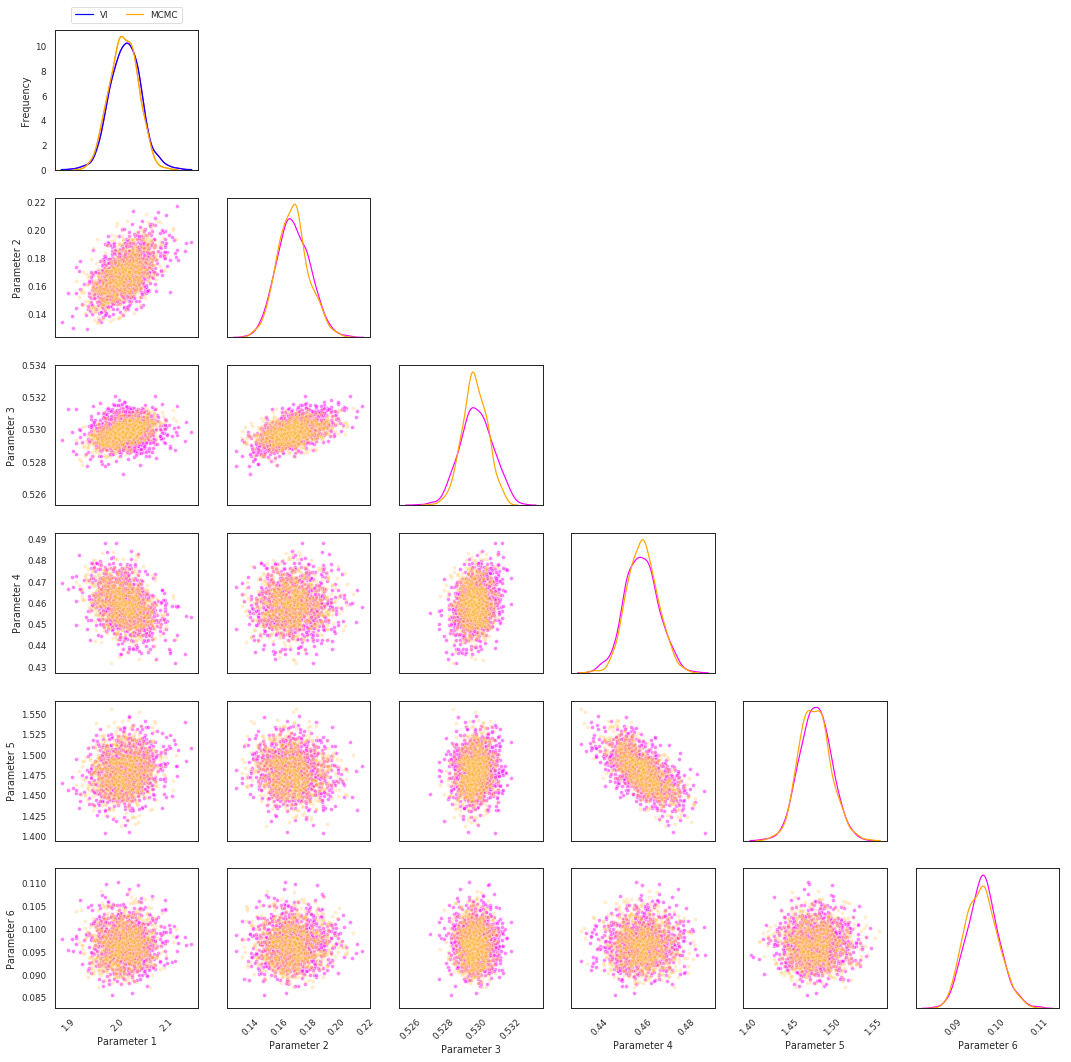

In [122]:
pairwise(vb_params,mc_params)